<a href="https://colab.research.google.com/github/KasraOstad/KSSAHSN/blob/main/KSSAHSN_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Workbook for KSSAHSN stage 1 interview exercise- Kasra Ostad Aghajani

## Load the data

In [1]:
#Load the libraries used in this workbook

import datetime
from datetime import date
from google.colab import files
import io
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import scipy.stats as stats


#Load the data:

uploaded = files.upload()


Saving KSS AHSN Interview Data Exercise v1.3.xlsx to KSS AHSN Interview Data Exercise v1.3.xlsx


In [2]:
#Read and store the Clincal and Operational data as pandas dataframes:

clinical=pd.read_excel(io.BytesIO(uploaded['KSS AHSN Interview Data Exercise v1.3.xlsx']), sheet_name=1)
operational=pd.read_excel(io.BytesIO(uploaded['KSS AHSN Interview Data Exercise v1.3.xlsx']), sheet_name=2)



## Demographics of PR patients in 2018

count    9885.000000
mean       60.868285
std        12.456921
min         6.000000
25%        53.000000
50%        61.000000
75%        68.000000
max       100.000000
Name: Age at initial appointment, dtype: float64

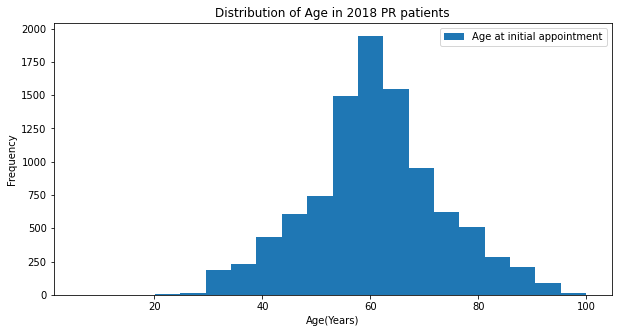

In [11]:
#Filter the data by date to only have patients referred in 2018:

time_Uthrehold = pd.Timestamp(2019, 1, 1)
time_Lthreshold= pd.Timestamp(2017, 12, 31)
filter_mask = clinical['Referral date'] < time_Uthrehold
clinical_2018 = clinical[filter_mask]
filter_mask = clinical_2018['Referral date'] > time_Lthreshold
clinical_2018 = clinical_2018[filter_mask]

#Remove patient with unknown age and convert ages to integer data type
clinical_2018 = clinical_2018[clinical_2018['Age at initial appointment'] != '#']
clinical_2018=clinical_2018.astype({'Age at initial appointment': 'int'})

#Define dataframe with information useful for demographic
demo=clinical_2018.loc[:,['Age at initial appointment','Gender','County']]

#Plot histogram of patient age distribution
ax=demo.plot.hist(bins=20,figsize=(10,5))
ax.set(xlabel='Age(Years)', title='Distribution of Age in 2018 PR patients')

#Compute statistical informationn on patient ages
demo['Age at initial appointment'].describe()



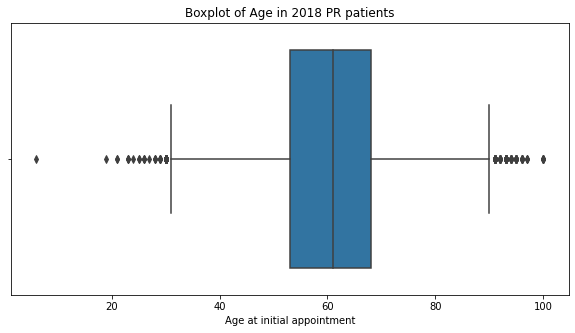

In [66]:
#Boxplot of patient ages
plt.figure(figsize=(10,5))
ax=sns.boxplot(x=demo['Age at initial appointment'])
ax.set(title='Boxplot of Age in 2018 PR patients')
plt.show()

We can see that the age of patients referred in 2018 are somewhat normally distributed with mean 60. Using the lower and upper quartiles, we can set a main age demographic of 53 to 68. 

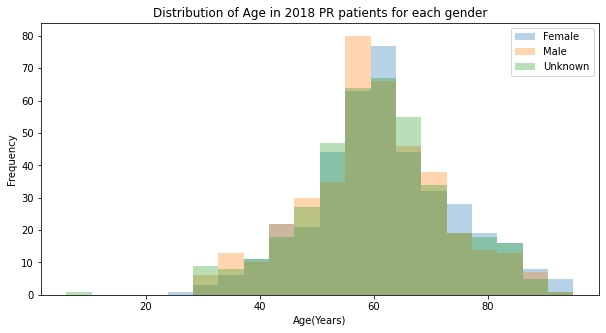

In [65]:
genders=list(demo['Gender'].unique())

sample_dict={}


for gender in genders:
  genderdf=demo[demo['Gender']==gender]
  gender_sample=genderdf.sample(n=400, random_state=0)
  sample_dict[gender]=gender_sample['Age at initial appointment'].tolist()

compare_gender_age=pd.DataFrame(data=sample_dict['Female'],columns=['Female'])
compare_gender_age['Male']=sample_dict['Male']
compare_gender_age['Unknown']=sample_dict['Unknown']

ax=compare_gender_age.plot.hist(bins=20,alpha=0.33, figsize=(10,5))
ax.set(xlabel='Age(Years)', title='Distribution of Age in 2018 PR patients for each gender')
plt.show()


The age distribution for each gender group does not seem to deviate from the age distribution of the overall population. 

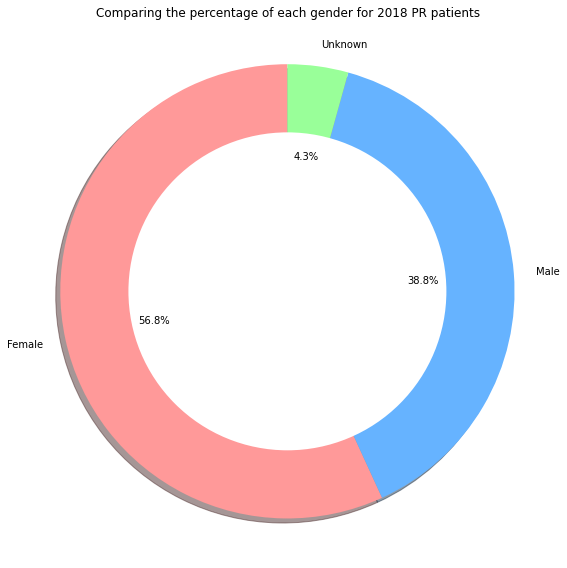

In [40]:
#Find the percentage of each gender in 2018 PR patients
gender_freq=[]
gender_percent=[]
gender_ages=[]

for gender in genders:
  df=demo[demo['Gender']==gender]
  gender_freq.append(len(df['Gender'].tolist()))

for freq in gender_freq:
  gender_percent.append((freq/sum(gender_freq))*100)


#Plot the gender percentages as a pie chart

colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.pie(gender_percent, labels=genders, autopct='%1.1f%%', shadow=True, startangle=90,colors=colors)
ax1.axis('equal')  

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
ax1.set(title='Comparing the percentage of each gender for 2018 PR patients')

plt.tight_layout()
plt.show()


We can see that there is a female majority in the PR patients referred in 2018.

## Insights from Clinical Data

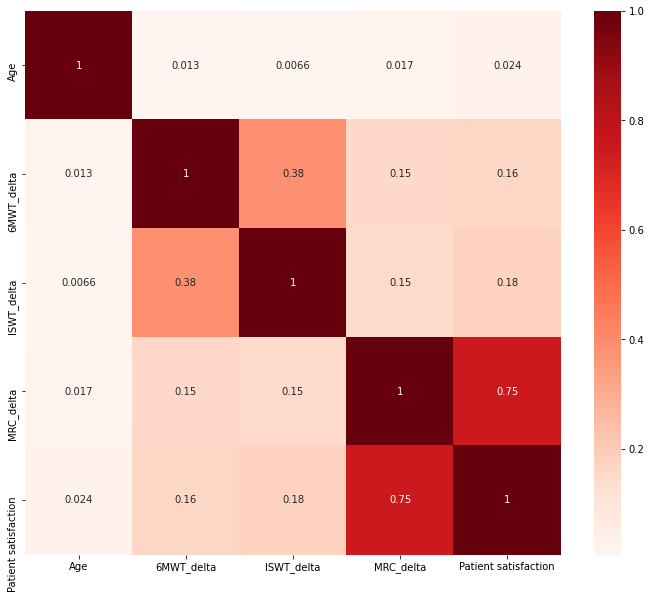

In [72]:
#Initial test is carried out on assessment date, PR begins on enrolment date, Final test carried out on completion date 

#Extract data for patients that have completed PR
clinical_completed=clinical.dropna(subset=['Completion date'])
clinical_completed=clinical_completed.drop(columns=['Patient identifier','Referred','Assessed','Referral date','Assessment date','Enrolment date','Completion date'])


#Calculate the difference in breathing tests and MRC scale for the patients
clinical_completed['6MWT_delta']=clinical_completed['6MWT After PR (m) [MCID = 30m]']-clinical_completed['6MWT Before PR (m)']
clinical_completed['ISWT_delta']=clinical_completed['ISWT After PR (m) [MCID = 48m]']-clinical_completed['ISWT Before PR (m)']
clinical_completed['MRC_delta']=clinical_completed['MRC After PR']-clinical_completed['MRC Before PR']

#Look for correlation between breathing tests and other variables
breathing_correlation=clinical_completed.loc[:,['Age at initial appointment','6MWT_delta','ISWT_delta','MRC_delta','Patient satisfaction']]
breathing_correlation = breathing_correlation[breathing_correlation['Age at initial appointment'] != '#']
breathing_correlation=breathing_correlation.astype({'Age at initial appointment': 'int'})
breathing_correlation=breathing_correlation.rename(columns={"Age at initial appointment": "Age"})

#Compute pairwise correlation of columns using Pearson's correlation coefficient
cor = breathing_correlation.corr(method='pearson')

#Plot Heatmap of correlations
ax = plt.figure(figsize=(12,10))
sns.heatmap(abs(cor), annot=True, cmap=plt.cm.Reds)
plt.show()


**Insights from heat map:**


1.   Patient Satisfaction is heavily correlated to  MRC_delta, more specifically, improvement in their MRC state. 
2.   6MWT and ISWT are equally correlated to MRC_delta
3. Age has minimal correlation with all other features
4. The second largest correlation are 6MWT and ISWT deltas with each other. Intuitively, when a patient improves in one test they will in the other as the breathing improves. 
5. ISWT_delta slightly more correlated to patient satisfaction than 6MWT_delta. Potentially due to it being the more complicated test


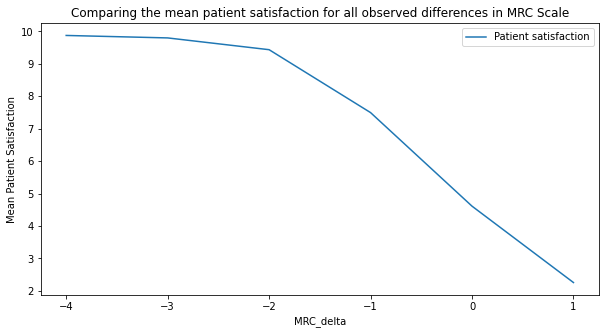

In [73]:
#Looking further into the heavy correlation between MRC_delta and Patient Satisfaction

#Plot the mean patient satisfaction for all the observed differences in MRC Scale
MRC_delta_vs_satisfaction=clinical_completed.loc[:,['MRC_delta','Patient satisfaction']]
fig, ax = plt.subplots(figsize=(10,5))
MRC_delta_vs_satisfaction.groupby(['MRC_delta']).mean().plot(ax=ax)
ax.set(ylabel='Mean Patient Satisfaction',title='Comparing the mean patient satisfaction for all observed differences in MRC Scale')
plt.show()

Although, it is intuitive that a greater improvement in breathing condition (smaller MRC delta) will cause greater patient satisfaction, we now have more evidence to use MRC_delta as a metric of performance for PR and the various AHSNs.

The mean MRC Delta for KSSAHSN is -1.3316412859560067
The mean MRC Delta for the rest of the AHSN is -1.2703525641025641


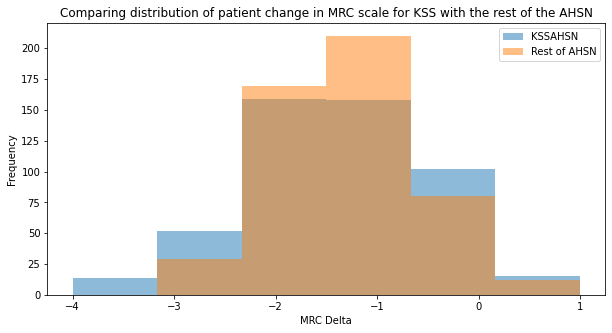

In [92]:
#Analysing the average change in MRC scale for KSS and the rest of the AHSNs

county_list=clinical_completed['County'].tolist()
AHN_list=[]
for county in county_list:
  if county in ['Kent','Surrey','West Sussex', 'East Sussex']:
    AHN_list.append('KSS')
  else:
    AHN_list.append('Rest')

clinical_completed['AHN']=AHN_list

KSS_completed=clinical_completed[clinical_completed['AHN']=='KSS'].loc[:,['MRC_delta']]
rest_completed=clinical_completed[clinical_completed['AHN']=='Rest'].loc[:,['MRC_delta']]

print('The mean MRC Delta for KSSAHSN is '+str(KSS_completed['MRC_delta'].mean()))
print('The mean MRC Delta for the rest of the AHSN is '+str(rest_completed['MRC_delta'].mean()))

kss_MRC=KSS_completed.sample(n=500, random_state=0)
kss_MRC=kss_MRC['MRC_delta'].tolist()

rest_MRC=rest_completed.sample(n=500, random_state=0)
rest_MRC=rest_MRC['MRC_delta'].tolist()

compare_MRC=pd.DataFrame(data=kss_MRC,columns=['KSSAHSN'])
compare_MRC['Rest of AHSN']=rest_MRC

ax=compare_MRC.plot.hist(bins=6,alpha=0.5, figsize=(10,5))
ax.set(xlabel='MRC Delta', title='Comparing distribution of patient change in MRC scale for KSS with the rest of the AHSN')
plt.show()


No noticable diffrence between KSS and the rest of the country for change in patient MRC scale.

The mean 6MWT Delta for patients with a practise test is 69.49181297815252
The mean 6MWT Delta for patients without a practise test is 32.25408239489268


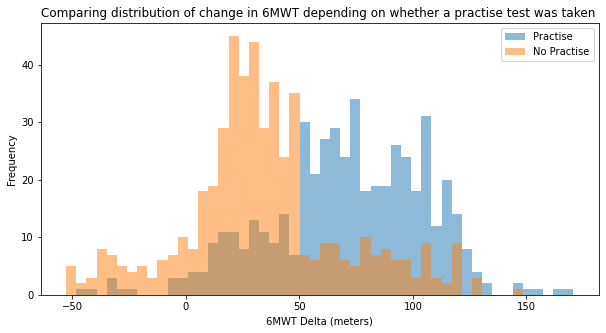

In [106]:
#Look into whether carrying out a practise makes a difference on 6MWT_delta

practise_6MWT=clinical_completed.loc[:,['Practice 6MWT carried out?','6MWT_delta','MRC_delta','Patient satisfaction']]
practise_6MWT_yes=practise_6MWT[practise_6MWT['Practice 6MWT carried out?']=='Yes']
practise_6MWT_no=practise_6MWT[practise_6MWT['Practice 6MWT carried out?']=='No']

print('The mean 6MWT Delta for patients with a practise test is '+str(practise_6MWT_yes['6MWT_delta'].mean()))
print('The mean 6MWT Delta for patients without a practise test is '+str(practise_6MWT_no['6MWT_delta'].mean()))


practise_6MWT_yes=practise_6MWT_yes.loc[:,['6MWT_delta']]
practise_6MWT_no=practise_6MWT_no.loc[:,['6MWT_delta']]

compare_6MWT_practise=practise_6MWT_yes.sample(n=500,random_state=0)
compare_6MWT_practise=compare_6MWT_practise.rename(columns={"6MWT_delta": "Practise"})

no_practise_sample=practise_6MWT_no.sample(n=500,random_state=0)
compare_6MWT_practise['No Practise']=no_practise_sample['6MWT_delta'].tolist()


ax=compare_6MWT_practise.plot.hist(bins=50,alpha=0.5,figsize=(10,5))
ax.set(xlabel='6MWT Delta (meters)', title='Comparing distribution of change in 6MWT depending on whether a practise test was taken ')
plt.show()

Testable Hypothesis 1: Patients that have had a practise 6MWT will experience a greater increase in meters during the second test after PR. 

<b> Hypothesis Test at a 5% significance level </b>

<b>Null hypothesis</b>: it is equally likely that a randomly selected 6MWT delta from patients that have had a practise test will be less than or greater than a randomly selected 6MWT delta from patients that have not had a practise test.

<b>Alternative hypothesis</b>: it is not equally likely that a randomly selected 6MWT delta from patients that have had a practise test will be less than or greater than a randomly selected 6MWT delta from patients that have not had a practise test.

In [114]:
#Mann-Whitney U non-parametric hypotheis test
hypothesis1 = stats.mannwhitneyu(compare_6MWT_practise['Practise'],compare_6MWT_practise['No Practise'],alternative='two-sided')
hypothesis1

MannwhitneyuResult(statistic=195359.0, pvalue=1.4665851618809827e-53)

We find the p-value to be below the criterion of 0.05. 

Therefore, we reject the null hypothesis and conclude that at a 95% confidence level, there is a statistically significant difference between patients that have had a practise 6MWT and those that have not. 

There appears to be a strong learning effect in the 6MWT so I would recommend nationally to standardise this test by allowing two tests to be carried out while picking the best score.


The mean ISWT Delta for patients with a practise test is 9.525959069787731
The mean ISWT Delta for patients without a practise test is 6.188643981619826


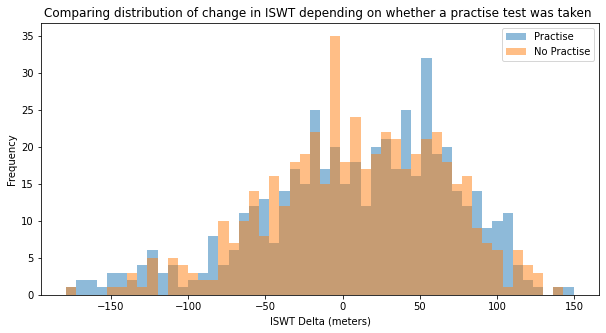

In [122]:
# Repeating for LSMT delta

practise_ISWT=clinical_completed.loc[:,['Practice ISWT carried out?','ISWT_delta','MRC_delta','Patient satisfaction']]
practise_ISWT_yes=practise_ISWT[practise_ISWT['Practice ISWT carried out?']=='Yes']
practise_ISWT_no=practise_ISWT[practise_ISWT['Practice ISWT carried out?']=='No']

print('The mean ISWT Delta for patients with a practise test is '+str(practise_ISWT_yes['ISWT_delta'].mean()))
print('The mean ISWT Delta for patients without a practise test is '+str(practise_ISWT_no['ISWT_delta'].mean()))

practise_ISWT_yes=practise_ISWT_yes.loc[:,['ISWT_delta']]
practise_ISWT_no=practise_ISWT_no.loc[:,['ISWT_delta']]

compare_ISWT_practise=practise_ISWT_yes.sample(n=500,random_state=0)
compare_ISWT_practise=compare_ISWT_practise.rename(columns={"ISWT_delta": "Practise"})

no_practise_sample=practise_ISWT_no.sample(n=500,random_state=0)
compare_ISWT_practise['No Practise']=no_practise_sample['ISWT_delta'].tolist()

ax=compare_ISWT_practise.plot.hist(bins=50,alpha=0.5,figsize=(10,5))
ax.set(xlabel='ISWT Delta (meters)', title='Comparing distribution of change in ISWT depending on whether a practise test was taken ')
plt.show()



No apparent difference in distribution which suggests that the ISWT test has a significantly less learning effect than 6MWT.

## Operational insights- Staffing issues

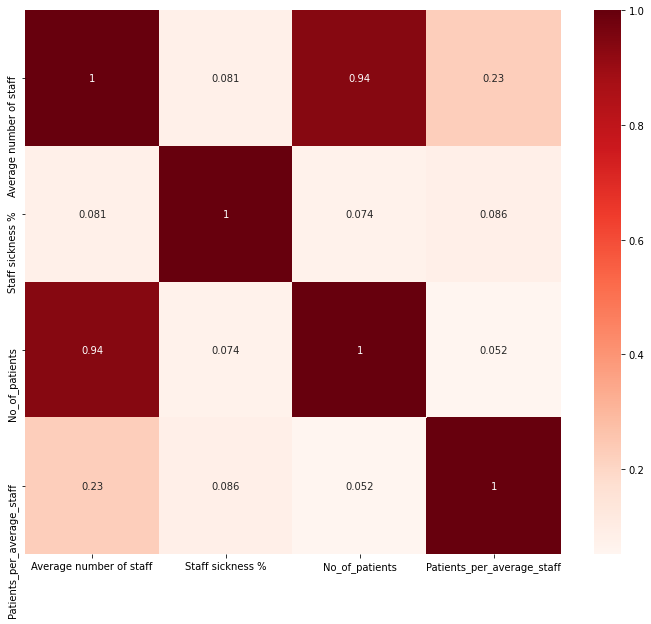

In [127]:
operational_counties=operational['County'].tolist()
patient_freq=[]


for county in operational_counties:
  countydf=clinical[clinical['County']==county]
  r, c = countydf.shape
  patient_freq.append(r)

operational['No_of_patients']=patient_freq

operational['Patients_per_average_staff']=operational['No_of_patients']/operational['Average number of staff']

plt.figure(figsize=(12,10))
cor = operational.corr()
sns.heatmap(abs(cor), annot=True, cmap=plt.cm.Reds)
plt.show()


Insights:


1.   Heavy Correlation between the average number of staff and the number of patients. A linear regression model can be used to suggest counties that are under/well staffed.
2.   No correlation between the number of patients per average staff and staff sickness.



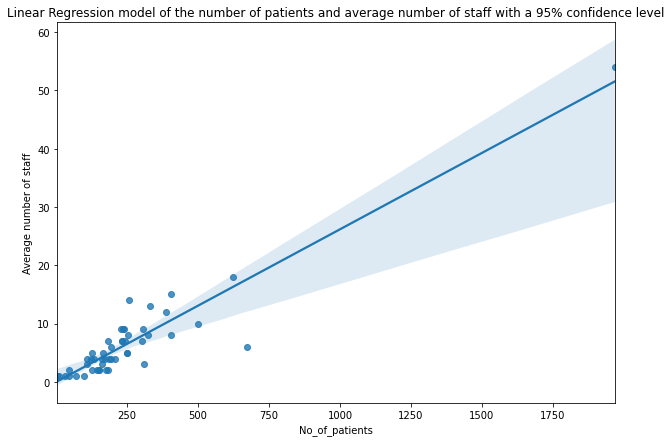

In [129]:
#Plotting the correlation between the no_of_patients and average number of staff 
#using a linear regression line with a 95% confidence level

plt.figure(figsize=(10,7))
ax=sns.regplot(x="No_of_patients", y="Average number of staff", data=operational)
ax.set_title('Linear Regression model of the number of patients and average number of staff with a 95% confidence level')
plt.show()

Instances below the 95% confidence level can be considered under staffed. Instances over the confidence level can be considered well staffed.

<Figure size 1080x360 with 0 Axes>

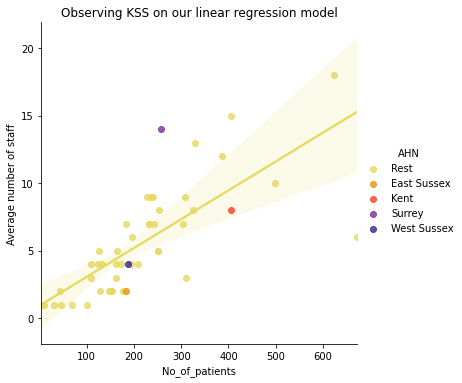

In [136]:
#Observing where KSS is on the model

county_list=operational['County'].tolist()
AHN_list=[]
for county in county_list:
  if county == 'Kent':
    AHN_list.append('Kent')
  elif county=='Surrey':
    AHN_list.append('Surrey')
  elif county=='West Sussex':
    AHN_list.append('West Sussex')
  elif county=='East Sussex':
    AHN_list.append('East Sussex')
  else:
    AHN_list.append('Rest')

operational['AHN']=AHN_list

#Removing london for closer observation
exclude_london=operational[operational['No_of_patients']<1000]
plt.figure(figsize=(15,5))
sns.lmplot(x="No_of_patients", y="Average number of staff", data=exclude_london,hue="AHN",palette='CMRmap_r')
ax=plt.gca()
ax.set_title('Observing KSS on our linear regression model')
plt.show()

Insights:


1. Surrey is one of the staffed counties nation wide.
2. Kent and West Sussex are reasonably staffed.
3. East Sussex is the most understaffed County in KSS and can be considered understaffed nation wide.



In [137]:
#Finding most under-staffed counties to recommend hiring more staff
under_staff=operational[operational['Average number of staff']<7]
under_staff=under_staff[under_staff['No_of_patients']>260]
under_staff

,County,Average number of staff,Staff sickness %,No_of_patients,Patients_per_average_staff,AHN
19,Greater Manchester,6,0.02,673,112.166667,Rest
38,South Yorkshire,3,0.08,310,103.333333,Rest


In [140]:
#Finding most well-staffed counties
well_staff=operational[operational['Average number of staff']>12]
well_staff=well_staff[well_staff['No_of_patients']<450]
well_staff

,County,Average number of staff,Staff sickness %,No_of_patients,Patients_per_average_staff,AHN
20,Hampshire,15,0.10,406,27.066667,Rest
25,Lancashire,13,0.07,330,25.384615,Rest
41,Surrey,14,0.03,258,18.428571,Surrey


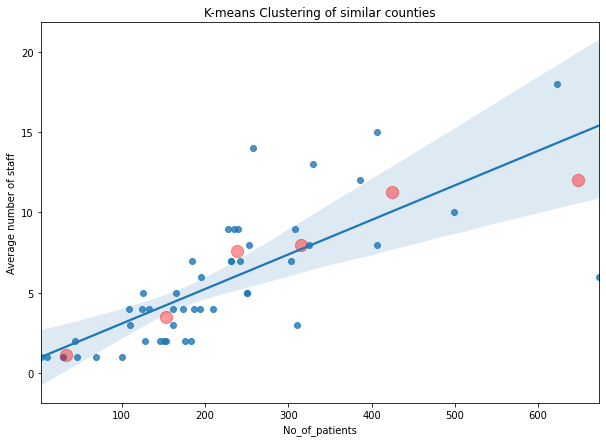

In [143]:
#Clustering counties together based on number of staff and patients can help 
#standardise the counties nationally and give recommendations on staff numbers or
#number of patients to take on 

clusterdf = exclude_london.loc[:,['No_of_patients','Average number of staff']]
  
kmeans = KMeans(n_clusters=6).fit(clusterdf)
centroids = kmeans.cluster_centers_

plt.figure(figsize=(10,7))
ax=sns.regplot(x="No_of_patients", y="Average number of staff", data=exclude_london)
ax.set_title('K-means Clustering of similar counties')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=150,alpha=0.4)
plt.show()

Observing the cluster each county falls into allows us to set targets for number of patients to take on and number of staff to hire.